In [18]:
import numpy as np
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score

In [19]:
class DecisionTreeRegressor:
    class Node:
        def __init__(
            self, left=None, right=None, feature=None, threshold=None, value=None
        ):
            self.left = left
            self.right = right
            self.value = value
            self.feature = feature
            self.threshold = threshold

        def isLeaf(self):
            return self.left is None and self.right is None

    def __init__(self, maxDepth: int = 5):
        self.maxDepth = maxDepth
        self.tree = None

    def fit(self, XTrain, yTrain):
        self.tree = self._buildTree(XTrain, yTrain)

    def _buildTree(self, XTrain, yTrain, depth=0):
        if len(yTrain) == 0:
            return None

        # If max depth reached or no variance, return leaf
        if depth >= self.maxDepth or self._getVariance(yTrain) == 0:
            leafValue = self._getLeafValue(yTrain)
            return self.Node(value=leafValue)

        feature, threshold = self._findBestSplit(XTrain, yTrain)

        # If no split improves variance, return leaf
        if feature is None or threshold is None:
            leafValue = self._getLeafValue(yTrain)
            return self.Node(value=leafValue)

        leftIndices, rightIndices = self._splitArray(XTrain[:, feature], threshold)

        leftXTrain, rightXTrain = XTrain[leftIndices], XTrain[rightIndices]
        leftYTrain, rightYTrain = yTrain[leftIndices], yTrain[rightIndices]

        left = self._buildTree(leftXTrain, leftYTrain, depth + 1)
        right = self._buildTree(rightXTrain, rightYTrain, depth + 1)

        return self.Node(
            left=left,
            right=right,
            feature=feature,
            threshold=threshold,
        )

    def _findBestSplit(self, XTrain, yTrain):
        bestVarianceReduction = -np.inf
        bestFeature = None
        bestThreshold = None

        if XTrain.shape[1] == 0:
            return None, None

        _, numFeatures = XTrain.shape
        for feature in range(numFeatures):
            possibleThresholds = np.unique(XTrain[:, feature])
            for threshold in possibleThresholds:
                leftIndices, rightIndices = self._splitArray(
                    XTrain[:, feature], threshold
                )

                if len(leftIndices) == 0 or len(rightIndices) == 0:
                    continue

                leftY, rightY = yTrain[leftIndices], yTrain[rightIndices]
                currentVarianceReduction = self._getVarianceReduction(
                    yTrain, leftY, rightY
                )

                if currentVarianceReduction > bestVarianceReduction:
                    bestVarianceReduction = currentVarianceReduction
                    bestFeature = feature
                    bestThreshold = threshold

        return bestFeature, bestThreshold

    def _splitArray(self, array, threshold):
        leftIndices = np.where(array <= threshold)[0]
        rightIndices = np.where(array > threshold)[0]

        return leftIndices, rightIndices

    def _getVarianceReduction(self, y, leftY, rightY):
        if len(y) == 0:
            return 0

        varParent = self._getVariance(y)
        varLeft = self._getVariance(leftY)
        varRight = self._getVariance(rightY)

        weightLeft = len(leftY) / len(y)
        weightRight = len(rightY) / len(y)

        return varParent - weightLeft * varLeft - weightRight * varRight

    def _getVariance(self, y):
        if len(y) == 0:
            return 0

        return np.var(y)

    def _getLeafValue(self, y):
        return np.mean(y)

    def predict(self, XTest):
        return np.array([self._predict(sample, self.tree) for sample in XTest])

    def _predict(self, XSample, node):
        if node.isLeaf():
            return node.value

        if XSample[node.feature] <= node.threshold:
            return self._predict(XSample, node.left)
        else:
            return self._predict(XSample, node.right)

In [20]:
class GradientBoostingClassifier:
    def __init__(self, nEstimators=100, learningRate=0.1, maxDepth=3):
        self.nEstimators = nEstimators
        self.learningRate = learningRate
        self.maxDepth = maxDepth

        self.numClasses = None
        self.trees = []
        self.initialPrediction = None

    def fit(self, XTrain, yTrain):
        numSamples = XTrain.shape[0]

        self.numClasses = np.max(yTrain) + 1
        self.trees = [[] for _ in range(self.numClasses)]
        self.initialPrediction = np.zeros((numSamples, self.numClasses))

        # Initialize Logits with initialPrediction
        currentLogits = self.initialPrediction.copy()

        yOneHotEncoded = np.eye(self.numClasses)[yTrain]

        for _ in range(self.nEstimators):
            # Compute probabilities
            probabilities = self._softmax(currentLogits)

            for currentClass in range(self.numClasses):
                residuals = (
                    yOneHotEncoded[:, currentClass] - probabilities[:, currentClass]
                )

                tree = DecisionTreeRegressor(maxDepth=self.maxDepth)
                tree.fit(XTrain, residuals)
                self.trees[currentClass].append(tree)

                currentLogits[:, currentClass] += self.learningRate * tree.predict(
                    XTrain
                )

    def predict(self, X):
        probabilities = self.predictProbabilities(X)

        return np.argmax(probabilities, axis=1)

    def predictProbabilities(self, X):
        numSamples = X.shape[0]

        logits = np.zeros((numSamples, self.numClasses))
        for currentClass in range(self.numClasses):
            for tree in self.trees[currentClass]:
                logits[:, currentClass] += self.learningRate * tree.predict(X)

        return self._softmax(logits)

    def _softmax(self, logits):
        expLogits = np.exp(logits - np.max(logits, axis=1, keepdims=True))

        return expLogits / np.sum(expLogits, axis=1, keepdims=True)


In [21]:
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_indices = np.random.choice(len(train_data), size=500, replace=False)
test_indices = np.random.choice(len(test_data), size=100, replace=False)

X_train = train_data.data[train_indices].numpy()
X_train = X_train.reshape(X_train.shape[0], -1)
y_train = train_data.targets[train_indices].numpy()

X_test = test_data.data[test_indices].numpy()
X_test = X_test.reshape(X_test.shape[0], -1)
y_test = test_data.targets[test_indices].numpy()

In [22]:
gb_model = GradientBoostingClassifier(nEstimators=10, maxDepth=2, learningRate=0.1)

gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_test)

gb_accuracy = accuracy_score(y_test, gb_predictions)
print(f"Custom Gradient Boosting Accuracy: {gb_accuracy:.3f}")

Custom Gradient Boosting Accuracy: 0.590


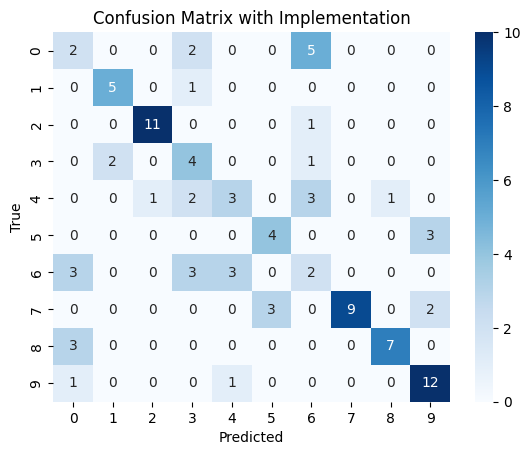

Precision (Weighted): 0.624
Recall (Weighted): 0.590
F1-Score (Weighted): 0.596


In [24]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, gb_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', vmin=0, vmax=10)

plt.title('Confusion Matrix with Implementation')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

precision_weighted = precision_score(y_test, gb_predictions, average='weighted')
recall_weighted = recall_score(y_test, gb_predictions, average='weighted')
f1_weighted = f1_score(y_test, gb_predictions, average='weighted')

print(f"Precision (Weighted): {precision_weighted:.3f}")
print(f"Recall (Weighted): {recall_weighted:.3f}")
print(f"F1-Score (Weighted): {f1_weighted:.3f}")
